In [32]:
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from tqdm import tqdm

In [33]:
L = 1e-5
N_x = 200
N_p = 5000
h = L/N_x
tau = 1e-14

In [34]:
n0 = 1e17
n1 = n0*N_x/N_p
q = 1.60217e-19
m = 9.1093837e-31
epsilon = 8.85e-12

In [35]:
T = 11600
k_b = 1.38e-23
alpha = -m/(2*k_b*T)
v_t = math.sqrt(3*k_b*T/m)
vmin = -3*v_t
vmax = 3*v_t

In [36]:
r_d = math.sqrt(epsilon * k_b * T / (q * q * n0));

In [37]:
w_theory = math.sqrt(n0*q*q/(m*epsilon))

In [38]:
r_d

2.3492626695468074e-05

In [39]:
h

5.0000000000000004e-08

In [40]:
particles = Particles(N_p, n1, -q, m)
nodes = Nodes(N_x)

In [41]:
set_homogeneous(particles, 0, L)

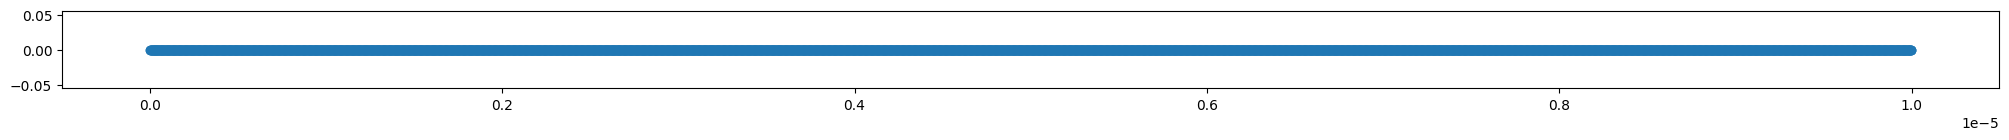

In [42]:
fig, ax = plt.subplots(1, 1)
ax.scatter(particles.x, np.zeros(particles.x.shape))
fig.set_size_inches((25, 1))


In [43]:
integral = get_integral(Maxwell(T, k_b, m), vmin, vmax, 100000)
set_distr(particles, integral)

In [44]:
max_v = np.max(particles.v)

In [45]:
courant = max_v*tau/h

In [46]:
particles.normalise(h, tau)

In [47]:
get_rho(nodes, particles, periodic=True)

In [48]:
ion_background = True

In [49]:
if ion_background:
    ion_constant = abs(nodes.rho[1].copy())
    nodes.rho += ion_constant

In [50]:
calc_fields(nodes, h, epsilon, periodic=True)

In [51]:
accel(particles, nodes, L, h, tau, zerostep=True)

In [52]:
n = 10000

In [53]:
kinetic_history = []
electric_history = []
summ_history = []

In [54]:
distrs_over_time = []

In [55]:
x_history = []

In [56]:
rho_history = []

In [57]:
phi_history = []

In [58]:
trajectory = []

In [59]:
for t in tqdm(range(n)):
    try:
        move(particles, nodes, mode="periodic", consistency=True)
    except Exception:
        print("number of iteration: ", t)
        break
    get_rho(nodes, particles, periodic=True)
    if ion_background:
        nodes.rho += ion_constant
    rho_history.append(nodes.rho.copy())
    calc_fields(nodes, h, epsilon, periodic=True)
    phi_history.append(nodes.phi.copy())
    #electric_history.append(calc_electric_energy(particles, nodes, h))
    accel(particles, nodes, L, h, tau)
    distrs_over_time.append(get_distr(particles, 0, 200))
    #kinetic_history.append(calc_kinetic_energy(particles, h, tau))
    x_history.append(particles.x[400])

100%|██████████| 10000/10000 [01:26<00:00, 115.90it/s]


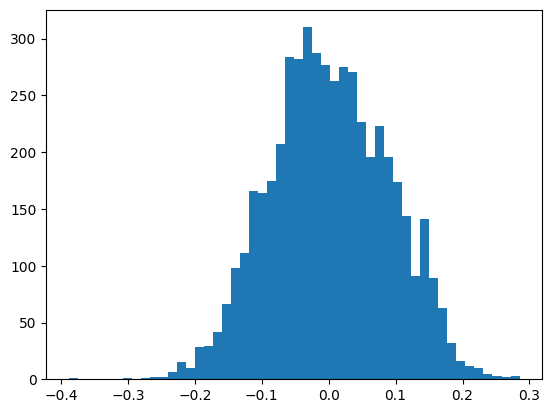

In [62]:
plt.hist(distrs_over_time[-1], bins=50)
%matplotlib inline

In [28]:
summ_history = []

In [29]:
for i in range(n):
    summ_history.append(kinetic_history[i] + electric_history[i])

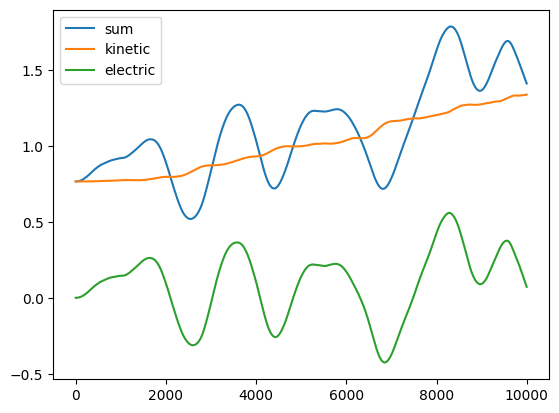

In [30]:
plt.plot(summ_history, label="sum")
plt.plot(kinetic_history, label="kinetic")
plt.plot(electric_history, label="electric")
plt.legend()
plt.show()

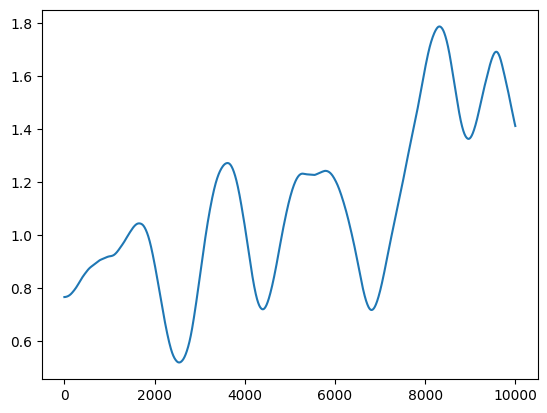

In [31]:
plt.plot(summ_history, label="sum")


In [32]:
kinetic_history[0]

0.7660990164664134

In [35]:
k = (np.max(electric_history)-np.min(electric_history))/(np.max(kinetic_history)-np.min(kinetic_history))

In [36]:
k

20.53784492341414

In [37]:
np.mean(np.array(summ_history))

0.7604603283573936

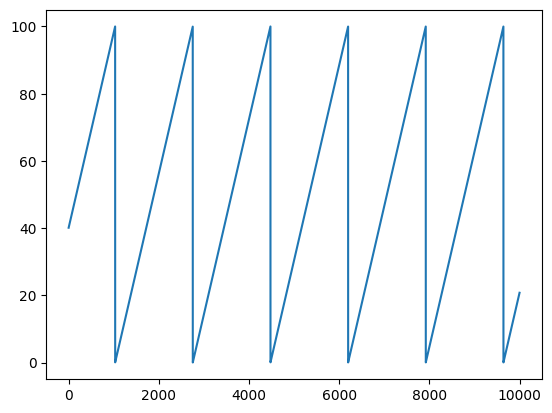

In [38]:
plt.plot(x_history)


In [63]:
import matplotlib.animation as animation

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

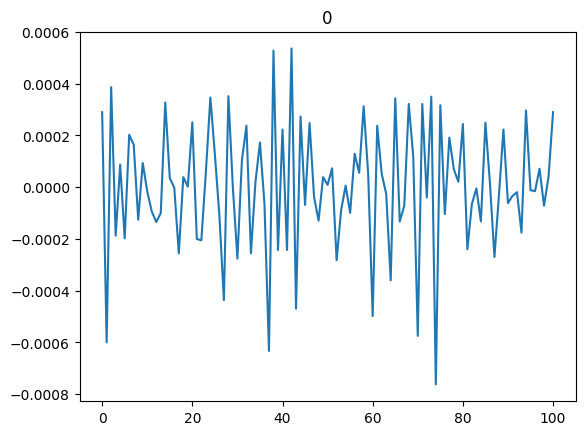

In [64]:
fig, ax = plt.subplots()

#  Создаем функцию, генерирующую картинки
#  для последующей "склейки":
def animate(i):
    ax.clear()
    line = ax.plot(rho_history[i*100])
    ax.set_title(str(i*100))
    return line

#  Создаем объект анимации:
sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=range(n),
                                      interval = 5,
                                      repeat = False)

#  Сохраняем анимацию в виде gif файла:
sin_animation.save('rho_over_time.gif',
                 writer='imagemagick', 
                 fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

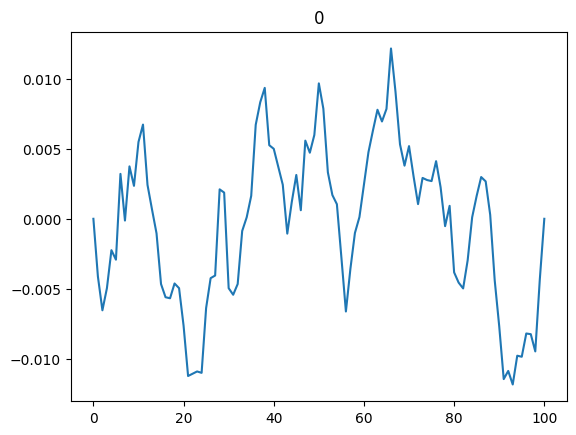

In [203]:
fig, ax = plt.subplots()

#  Создаем функцию, генерирующую картинки
#  для последующей "склейки":
def animate(i):
    ax.clear()
    line = ax.plot(phi_history[i*100])
    ax.set_title(str(i*100))
    return line

#  Создаем объект анимации:
sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=range(n),
                                      interval = 5,
                                      repeat = False)

#  Сохраняем анимацию в виде gif файла:
sin_animation.save('phi_over_time.gif',
                 writer='imagemagick', 
                 fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

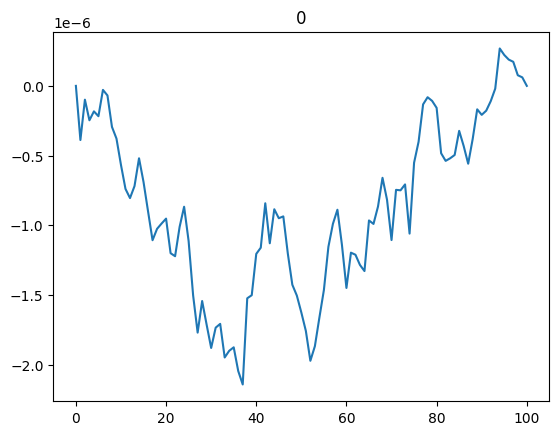

In [65]:
fig, ax = plt.subplots()

#  Создаем функцию, генерирующую картинки
#  для последующей "склейки":
def animate(i):
    ax.clear()
    line = ax.plot(phi_history[i*100])
    ax.set_title(str(i*100))
    return line

#  Создаем объект анимации:
sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=range(n),
                                      interval = 5,
                                      repeat = False)

#  Сохраняем анимацию в виде gif файла:
sin_animation.save('distrs_over_time.gif',
                 writer='imagemagick', 
                 fps=30)

In [38]:
from matplotlib import animation

MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

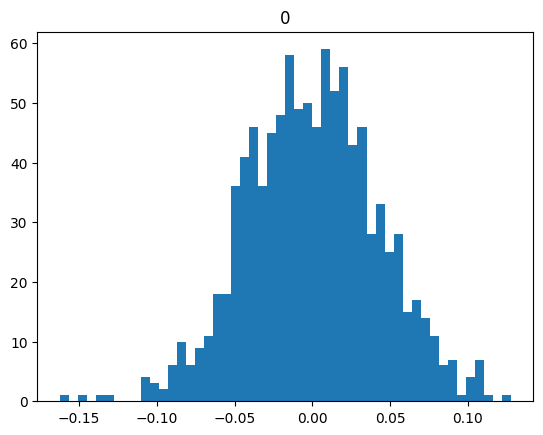

In [97]:
fig, ax = plt.subplots()

#  Создаем функцию, генерирующую картинки
#  для последующей "склейки":
def animate(i):
    ax.clear()
    line = ax.hist(distrs_over_time[i*100], bins=50)
    ax.set_title(str(i*100))
    return line

#  Создаем объект анимации:
sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=range(n),
                                      interval = 5,
                                      repeat = False)

#  Сохраняем анимацию в виде gif файла:
sin_animation.save('distrs_over_time.gif',
                 writer='imagemagick', 
                 fps=30)

In [ ]:
fig, ax = plt.subplots()

#  Создаем функцию, генерирующую картинки
#  для последующей "склейки":
def animate(i):
    ax.clear()
    line = ax.plot(rho_history[i*100])
    ax.set_title(str(i*100))
    return line

#  Создаем объект анимации:
sin_animation = animation.FuncAnimation(fig, 
                                      animate, 
                                      frames=range(n),
                                      interval = 5,
                                      repeat = False)

#  Сохраняем анимацию в виде gif файла:
sin_animation.save('distrs_over_time.gif',
                 writer='imagemagick', 
                 fps=30)